In [1]:
from collections import defaultdict
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # Para graficar la trayectoria
from ultralytics import YOLO

In [2]:
# Cargar el modelo YOLOv8
model = YOLO("yolov8n.pt")

## Obtener centroides de carros

In [3]:
# Ruta de la imagen


def find_objects_centroids(class_numbers, image_path):
    centroid = []
    image = cv2.imread(image_path)

    # Detectar mesas 
    results = model(image, classes= class_numbers, conf = 0.5)  

    # Extraer las cajas de detección
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Coordenadas de las cajas delimitadoras
    scores = results[0].boxes.conf.cpu().numpy()  # Confianza de las detecciones

    # Dibujar las cajas en la imagen
    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Caja verde
        cv2.putText(image, f'{score:.2f}', (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        center_x = int(((x2 - x1) // 2) + x1)
        center_y = int(((y2 - y1) // 2 ) + y1)
        centroid.append((center_x, center_y))  


    # Mostrar la imagen con las detecciones
    cv2.imshow("Detected Tables", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return centroid


In [4]:
image_path = "cars.jpg"
class_numbers = [2]
centroid = find_objects_centroids(class_numbers, image_path)
centroid


0: 384x640 3 cars, 260.8ms
Speed: 18.2ms preprocess, 260.8ms inference, 7.8ms postprocess per image at shape (1, 3, 384, 640)


[(449, 543), (1459, 404), (1074, 320)]

In [5]:
# Ruta del video
video_path = "prueba_cars.mp4"
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = int(cap.get(cv2.CAP_PROP_FPS))


# Diccionario para almacenar el historial completo de las posiciones (x, y) por cada ID
track_history = defaultdict(lambda: [])


In [6]:
def person_tracker(video_path, centroid, threshold):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Diccionario para almacenar el historial completo de las posiciones (x, y) por cada ID
    track_history = defaultdict(lambda: [])
    # Loop a través de los frames del video
    while cap.isOpened():
        success, frame = cap.read()

        if success:
            # Ejecuta el seguimiento con YOLOv8 solo para personas (clase 0)
            results = model.track(frame, persist=True, classes=[0], conf=0.5)

            # Verificar si hay detecciones antes de acceder a las cajas e IDs
            if results[0].boxes is not None:
                boxes = results[0].boxes.xywh.cpu()  # Coordenadas de las cajas delimitadoras

                # Verificar si hay track IDs
                track_ids = results[0].boxes.id
                if track_ids is not None:
                    track_ids = track_ids.int().cpu().tolist()  # Convertir a lista si los IDs existen

                    # Visualiza los resultados en el frame
                    annotated_frame = results[0].plot()

                    # Guarda las posiciones de cada ID
                    for box, track_id in zip(boxes, track_ids):
                        x, y, w, h = box
                        track = track_history[track_id]
                        track.append((float(x), float(y)))  # Guardar la posición del centro del cuadro (x, y)


                        # Dibujar las líneas de seguimiento
                        #points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                        #cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=10)
                        #cv2.putText(annotated_frame, "(" + str(float(x)) + "," + str(float(y)) + ")", (int(x), int(y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                        #cv2.circle(annotated_frame, (centroid[0][0], centroid[0][1]), radius=200, color=(0, 255, 0), thickness=2)
                    # Mostrar el video con las anotaciones
                    #cv2.imshow("YOLOv8 Tracking", annotated_frame)

            # Salir si se presiona 'q'
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
        else:
            # Finaliza cuando el video se haya procesado completamente
            break

    # Libera el video y cierra la ventana
    cap.release()
    cv2.destroyAllWindows()

    # Guardar el historial completo de posiciones en un archivo CSV
    track_data = []

    # Convertir el diccionario de track_history a una lista de filas
    for track_id, positions in track_history.items():
        for frame_num, (x, y) in enumerate(positions):
            track_data.append([track_id, frame_num, x, y])

    # Crear un DataFrame para organizar los datos
    df = pd.DataFrame(track_data, columns=['ID', 'Frame', 'X', 'Y'])

    def inbound(row, x, y, threshold):
        # Euclidean distance formula
        distance = np.sqrt((row['X'] - x)*2 + (row['Y'] - y)*2)
        
        # Return 1 if distance is below threshold, otherwise return 0
        return 1 if distance < threshold else 0


    for point in centroid:
        df[str(point)] = df.apply(inbound, axis=1, args=(point[0], point[1], threshold))
    
    column_names = [str(point) for point in centroid]

    # Add 'ID' to the column names
    column_names = ['ID'] + column_names

    # Create an empty DataFrame with the dynamic column names
    df_summarize = pd.DataFrame(columns=column_names)


    df_summarize = pd.DataFrame(columns=df_summarize.columns)  # Initialize the summarized DataFrame

    for client in df['ID'].unique():
        new_row = [client]
        df_copy = df
        filter_df = df_copy[df_copy ['ID'] == client]
        total_screentime = filter_df.shape[0]
        
        # Iterate through the columns and calculate the average for relevant columns
        for column in df.columns:
            if '(' in column:
                new_row.append(filter_df[column].sum() / total_screentime)
        
        # Create a new DataFrame row from the new_row list
        new_row_df = pd.DataFrame([new_row], columns=df_summarize.columns)
        
        # Concatenate the new row to the df_summarize DataFrame
        df_summarize = pd.concat([df_summarize, new_row_df], ignore_index=True)


    return df, df_summarize

In [7]:
video_path = "prueba_cars.mp4"
threshold = 200
df_general, df_tracker = person_tracker(video_path, centroid, threshold)
df_tracker.head()


0: 384x640 (no detections), 84.6ms
Speed: 9.6ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 72.8ms
Speed: 7.0ms preprocess, 72.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 78.3ms
Speed: 1.5ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 85.3ms
Speed: 4.7ms preprocess, 85.3ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 99.3ms
Speed: 3.4ms preprocess, 99.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 109.0ms
Speed: 0.0ms preprocess, 109.0ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 106.6ms
Speed: 9.8ms preprocess, 106.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 105.6ms
Speed: 9.1ms preprocess, 105

C:\Users\santi\AppData\Local\Temp\ipykernel_3100\2788374.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_summarize = pd.concat([df_summarize, new_row_df], ignore_index=True)


,ID,"(449, 543)","(1459, 404)","(1074, 320)"
0,1,0.263889,0.500000,1.440657
1,2,0.294366,0.557746,1.607042
2,3,1.174157,2.224719,6.410112
3,5,0.337641,0.639742,1.843296
4,6,0.590395,1.118644,3.223164


In [8]:
df_tracker.head()

,ID,"(449, 543)","(1459, 404)","(1074, 320)"
0,1,0.263889,0.500000,1.440657
1,2,0.294366,0.557746,1.607042
2,3,1.174157,2.224719,6.410112
3,5,0.337641,0.639742,1.843296
4,6,0.590395,1.118644,3.223164


Build heatmap

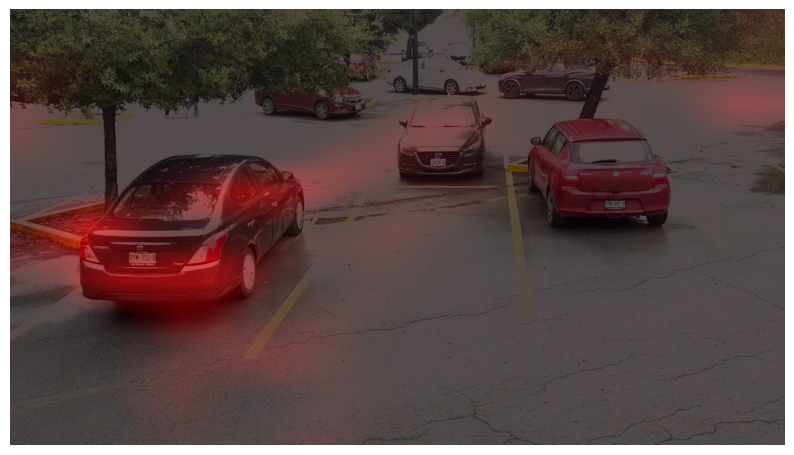

In [9]:
import matplotlib.cm as cm
import seaborn as sns

# Lee la imagen

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convierte de BGR a RGB

# Tamaño del heatmap
heatmap_size = (image.shape[1], image.shape[0])

# Define el número de bins (ajusta según necesidad)
bins_x = 25
bins_y = 25

# Crea el histograma 2D (heatmap data)
heatmap_data, xedges, yedges = np.histogram2d(df_general['X'], df_general['Y'], bins=(bins_x, bins_y))

# Normaliza los datos del heatmap
heatmap_data = np.clip(heatmap_data / np.max(heatmap_data), 0, 1)

heatmap_data = cv2.GaussianBlur(heatmap_data, (3, 3), 0)

# Aplica un mapa de color
heatmap_colormap = plt.get_cmap('hot')
heatmap_color = heatmap_colormap(heatmap_data)
heatmap_color = (heatmap_color[:, :, :3] * 255).astype(np.uint8)

# Asegúrate de que el tamaño del mapa de calor sea el mismo que la imagen
heatmap_color = cv2.resize(heatmap_color, (heatmap_size[0], heatmap_size[1]))

# Fusiona el heatmap con la imagen original
alpha = 0.7  # Ajusta la transparencia
overlay = cv2.addWeighted(image, 1 - alpha, heatmap_color, alpha, 0)

# Muestra el resultado
plt.figure(figsize=(10, 8))
plt.imshow(overlay)
plt.axis('off')  # Elimina el eje
plt.show()
